# Example hologram processing pipeline

### Step 00 - configure warnings and autoreload

In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

### Step 01 - Imports

In [2]:
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import os

from pyopia.classify import Classify
import pyopia.process
import pyopia.io
import pyopia.background
import pyopia.statistics
import pyopia.plotting
import skimage.io
from pyopia.pipeline import Pipeline
import pyopia.instrument.holo as holo
import pyopia.exampledata as exampledata

### Step 02 - (run once) Download test data set

In [3]:
# download the holo test data
# either holo_test_data_01 (default) or holo_test_data_02
infolder = exampledata.get_folder_from_holo_repository("holo_test_data_01", existsok=True)
infolder = os.path.join(infolder, "*.pgm")

holo_test_data_01 already exists. Skipping download.


### Step 03 - Define input and output locations

In [4]:
# path to folder of input data
infolder = 'holo_test_data_01/*.pgm'

# path to folder of output data (will be created)
outfolder = 'proc-pipeline-holo'

# name of output statistics file (if already exists will be removed)
outfilename = 'holotest'

# path to classifier model to use (here we download and use an example model)
model_path = exampledata.get_example_model()

### Step 04 - Setup folders configured in Step 03

In [5]:
# make output folder
os.makedirs(outfolder, exist_ok=True)

# remove pre-existing output file (as statistics for each image are appended to it)
datafile = os.path.join(outfolder, outfilename)
datafile_nc = datafile + '-STATS.nc'
if os.path.isfile(datafile_nc):
  os.remove(datafile_nc)

### Step 05 - Setup pipeline steps

In [6]:
# define the configuration to use in the processing pipeline - given as a dictionary - with some values defined above
pipeline_config = {
   'general': {
      'raw_files': infolder,
      'pixel_size': 4.4 # pixel size in um 
   },
 'steps': {
      ### start of steps run once on pipeline initialisation
      # initial step to setup hologram reconstruction kernel - arguments are hologram reconstruction settings
      'initial': {
         'pipeline_class': 'pyopia.instrument.holo.Initial',
         'wavelength': 658, # laser wavelength in nm
         'n': 1.33, # index of refraction of sample volume medium (1.33 for water)
         'offset': 27, # offset to start of sample volume in mm
         'minZ': 0, # minimum reconstruction distance within sample volume in mm
         'maxZ': 50, # maximum reconstruction distance within sample volume in mm
         'stepZ': 0.5 #step size in mm
      },
      # sets up classifier model, runs once on pipeline initialisation - argument is the path to the classification model to use from Step 03
      'classifier': {
         'pipeline_class': 'pyopia.classify.Classify',
         'model_path': model_path
      },
      ### start of steps applied to every image
      # load the image using instrument-specific loading function 
      'load': {
         'pipeline_class': 'pyopia.instrument.holo.Load'
      },
      # apply background correction - argument is which method to use:
      # 'accurate' - recommended method for moving background
      # 'fast' - faster method for realtime applications
      # 'pass' - omit background correction
      'correctbackground': {
         'pipeline_class': 'pyopia.background.CorrectBackgroundAccurate',
         'average_window': 10,
         'bgshift_function': 'accurate'
      },
      # hologram reconstruction step - arguments are:
      # stack_clean - is how much stack cleaning (% dimmest pixels to remove) to apply - set to 0 to omit cleaning
      # forward_filter_option - switch to control filtering in frequency domain (0=none,1=DC only,2=zero ferquency/default)
      # inverse_output_option - switch to control optional scaling of output intensity (0=square/default,1=linear)
      'reconstruct': {
         'pipeline_class': 'pyopia.instrument.holo.Reconstruct',
         'stack_clean': 0.02,
         'forward_filter_option': 2,
         'inverse_output_option': 0
      },
      # focussing step - arguments are:
      # which summarisation method to use:
      # 'std_map' (default) - takes standard deviation of values through stack
      # 'max_map' - takes maximum intensity value through stack
      # threshold is global segmentation threshold to apply to stack summary
      # which focus function to use:
      # 'find_focis_imax' (default) - finds focus using plane of maximum intensity
      # 'find_focus_sobel' - finds focus using edge sharpness
      # focus options are:
      # increase_depth_of_field (bool, default False) - finds max of planes adjacent to optimum focus plane
      # merge_adjacent_particles (int, default 0) - merges adjacent particles within stack summary using this pixel radius
      'focus': {
         'pipeline_class': 'pyopia.instrument.holo.Focus',
         'stacksummary_function': 'max_map',
         'threshold': 0.97,
         'increase_depth_of_field': True,
         'focus_function': 'find_focus_sobel',
         'merge_adjacent_particles': 2
      },
      # segmentation of focussed particles - argument is threshold to apply (can be different to Focus step)
      'segmentation': {
         'pipeline_class': 'pyopia.process.Segment',
         'threshold': 0.99,
         'segment_source': 'im_focussed'
      },
      # extraction of particle statistics - arguments are:
      # export_outputpath - is output folder for image-specific outputs for montage creation (can be omitted)
      # propnames - is list of skimage regionprops to export to stats (optional - must contain default values that can be appended to)
      'statextract': {
         'pipeline_class': 'pyopia.process.CalculateStats',
         'export_outputpath': outfolder, 
         'propnames': ['major_axis_length', 'minor_axis_length', 'equivalent_diameter', 
                              'feret_diameter_max', 'equivalent_diameter_area'],
         'roi_source': 'im_focussed'
      },
      # step to merge hologram-specific information (currently focus depth & original filename) into output statistics file
      'mergeholostats': {
         'pipeline_class': 'pyopia.instrument.holo.MergeStats',
      },
      # write the output NetCDF statistics file
      'output': {
         'pipeline_class': 'pyopia.io.StatsToDisc',
         'output_datafile': datafile
      }
   }
}

# now initialise the pipeline
processing_pipeline = Pipeline(pipeline_config)

Initialising pipeline
Initial  ready with: {'wavelength': 658, 'n': 1.33, 'offset': 27, 'minZ': 0, 'maxZ': 50, 'stepZ': 0.5}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files'])
Using first raw file from list in general settings to determine image dimensions
Build kernel with pixel_size =  4.4 um
HoloInitial done 2024-08-13 11:23:45.475230
Classify  ready with: {'model_path': 'keras_model.h5'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack'])


### Step 06 - Run the pipeline

In [7]:
# get sorted list of input files
files = sorted(glob(infolder))

# initialise background with first 10 images
for filename in files[:10]:
    processing_pipeline.run(filename)

# now process from the start
for filename in files[:5]:
    processing_pipeline.run(filename)

Load  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack', 'filename'])
holo_test_data_01/001-2043.pgm
D20180706T181539.002043
2018-07-06 18:15:39.002043
CorrectBackgroundAccurate  ready with: {'average_window': 10, 'bgshift_function': 'accurate'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack', 'filename', 'timestamp', 'imraw'])
Skipping remaining steps of the pipeline and returning
Load  ready with: {}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
holo_test_data_01/001-2044.pgm
D20180706T181545.002044
2018-07-06 18:15:45.002044
CorrectBackgroundAccurate  ready with: {'average_window': 10, 'bgshift_function': 'accurate'}  and data dict_keys(['cl', 'settings', 'skip_next_steps', 'raw_files', 'kern', 'im_stack', 'filename', 'timestamp', 'imraw', 'bgstack', 'imbg'])
Skipping remaining steps of the

### Step 07 - Review outputs

In [8]:
xstats = pyopia.io.load_stats(datafile_nc)
xstats

<xarray.Dataset>
Dimensions:                     (index: 869)
Coordinates:
  * index                       (index) int32 0 1 2 3 4 ... 193 194 195 196 197
    time                        (index) datetime64[ns] 2018-07-06T18:15:39.00...
Data variables: (12/21)
    holo_filename               (index) object 'holo_test_data_01/001-2043.pg...
    export name                 (index) object 'D20180706T181539.002043-PN0' ...
    major_axis_length           (index) float64 6.258 7.008 ... 4.362 10.15
    minor_axis_length           (index) float64 4.158 4.016 ... 3.757 4.631
    equivalent_diameter         (index) float64 5.171 4.918 10.22 ... 4.068 6.58
    feret_diameter_max          (index) float64 6.325 7.28 16.16 ... 4.472 10.77
    ...                          ...
    probability_copepod         (index) float64 0.0004639 5.666e-05 ... 6.79e-05
    probability_diatom_chain    (index) float64 0.9557 0.9876 ... 0.8489 0.9568
    probability_oily_gas        (index) float64 0.001579 0.0001519 ... 0.0007377
    timestamp                   (index) datetime64[ns] 2018-07-06T18:15:39.00...
    saturation                  (index) float64 1.57 1.57 1.57 ... 1.915 1.915
    ifocus                      (index) int32 85 23 89 89 55 ... 63 63 40 40 21
Attributes:
    steps:           [general]\nraw_files = "holo_test_data_01/*.pgm"\npixel_...
    Modified:        2024-08-13 11:23:51.802091
    PyOpia version:  1.1.8

In [9]:
print(pyopia.statistics.count_images_in_stats(xstats), 'images found in stats data')

5 images found in stats data


Text(0, 0.5, 'Volume Distribution [uL/sample vol.]')

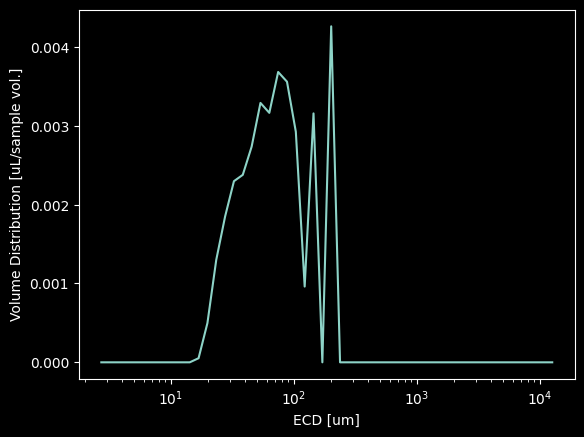

In [10]:
# Calculate the volume distribution from the stats DataFrame.
dias, vd = pyopia.statistics.vd_from_stats(xstats, pyopia.pipeline.steps_from_xstats(xstats)['general']['pixel_size'])

# plot the volume distribution
plt.style.use('dark_background')
plt.plot(dias, vd)
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')

Text(0.5, 0, 'Z [mm]')

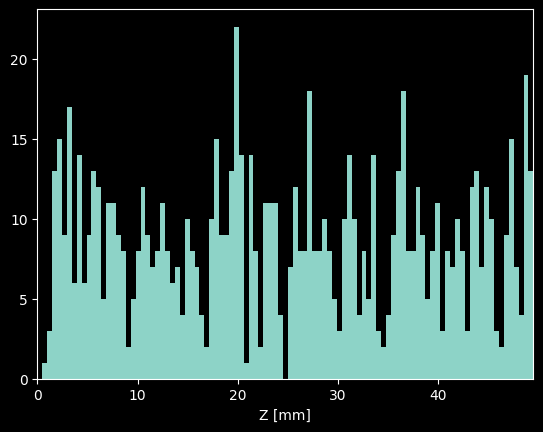

In [11]:
# plot histogram of focus locations
import numpy as np

pipeline_steps = pyopia.pipeline.steps_from_xstats(xstats)['steps']

plt.style.use('dark_background')
zval = np.arange(pipeline_steps['initial']['minZ'],
                 pipeline_steps['initial']['maxZ'],
                 pipeline_steps['initial']['stepZ'])
plt.hist(zval[xstats.ifocus-1],len(zval))
plt.xlim(zval[0],zval[-1])
plt.xlabel('Z [mm]')

rofiles: 868
reducing particles by factor of 1
rofiles: 868
making a montage - this might take some time....


100%|██████████| 868/868 [00:00<00:00, 7625.80it/s]

montage complete


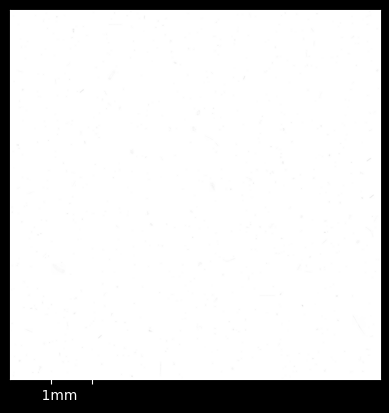

In [12]:
# create montage of focussed particles
im_mont = pyopia.statistics.make_montage(datafile_nc,
                                         pyopia.pipeline.steps_from_xstats(xstats)['general']["pixel_size"],
                                         outfolder,
                                         auto_scaler=1000, msize=2048, maxlength=100000, crop_stats=None, eyecandy=False)
pyopia.plotting.montage_plot(im_mont, pyopia.pipeline.steps_from_xstats(xstats)['general']["pixel_size"])

In [13]:
# export rois of subset of particles (e.g. long, thin particles)
min_major_axis_um = 100
max_minor_axis_um = 40
roifolder = 'long_thin_example'

os.makedirs(roifolder, exist_ok=True)

long_thin_parts=xstats.where((xstats['major_axis_length'] > min_major_axis_um/pyopia.pipeline.steps_from_xstats(xstats)['general']["pixel_size"])
                             & (xstats['minor_axis_length'] < max_minor_axis_um/pyopia.pipeline.steps_from_xstats(xstats)['general']["pixel_size"]),
                             drop=True)

roifiles = pyopia.statistics.gen_roifiles(long_thin_parts)

for roi in roifiles:
    im = pyopia.statistics.roi_from_export_name(roi, outfolder)
    outfilename = os.path.join(roifolder ,roi + '.bmp')
    skimage.io.imsave(outfilename, np.uint8(np.array(im) * 255))

rofiles: 35
reducing particles by factor of 1
rofiles: 35
